# ATAC-seq Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

In [2]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Functions

In [3]:

def get_matched_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
        
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]


    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Preprocessing

In [4]:
# file directories
workingDirectory = '/home/jenhan/analysis/atac_analysis/'

genomes = ['hg19','mm10', 'hg38']
scratchDirectory = workingDirectory + '/scratch/'


### RNA-seq

In [5]:

tagDirPath = workingDirectory + '/tag_directories_rna/'


os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['Cell Type'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

### ATAC-seq

In [6]:

tagDirPath = workingDirectory + '/tag_directories_atac/'

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), 
                                                  list(summary_frame['Cell Type'].values), 
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_atac.tsv', sep='\t', index=False)
summary_frame_atac = summary_frame.copy()

## Filter Data on QC Metrics

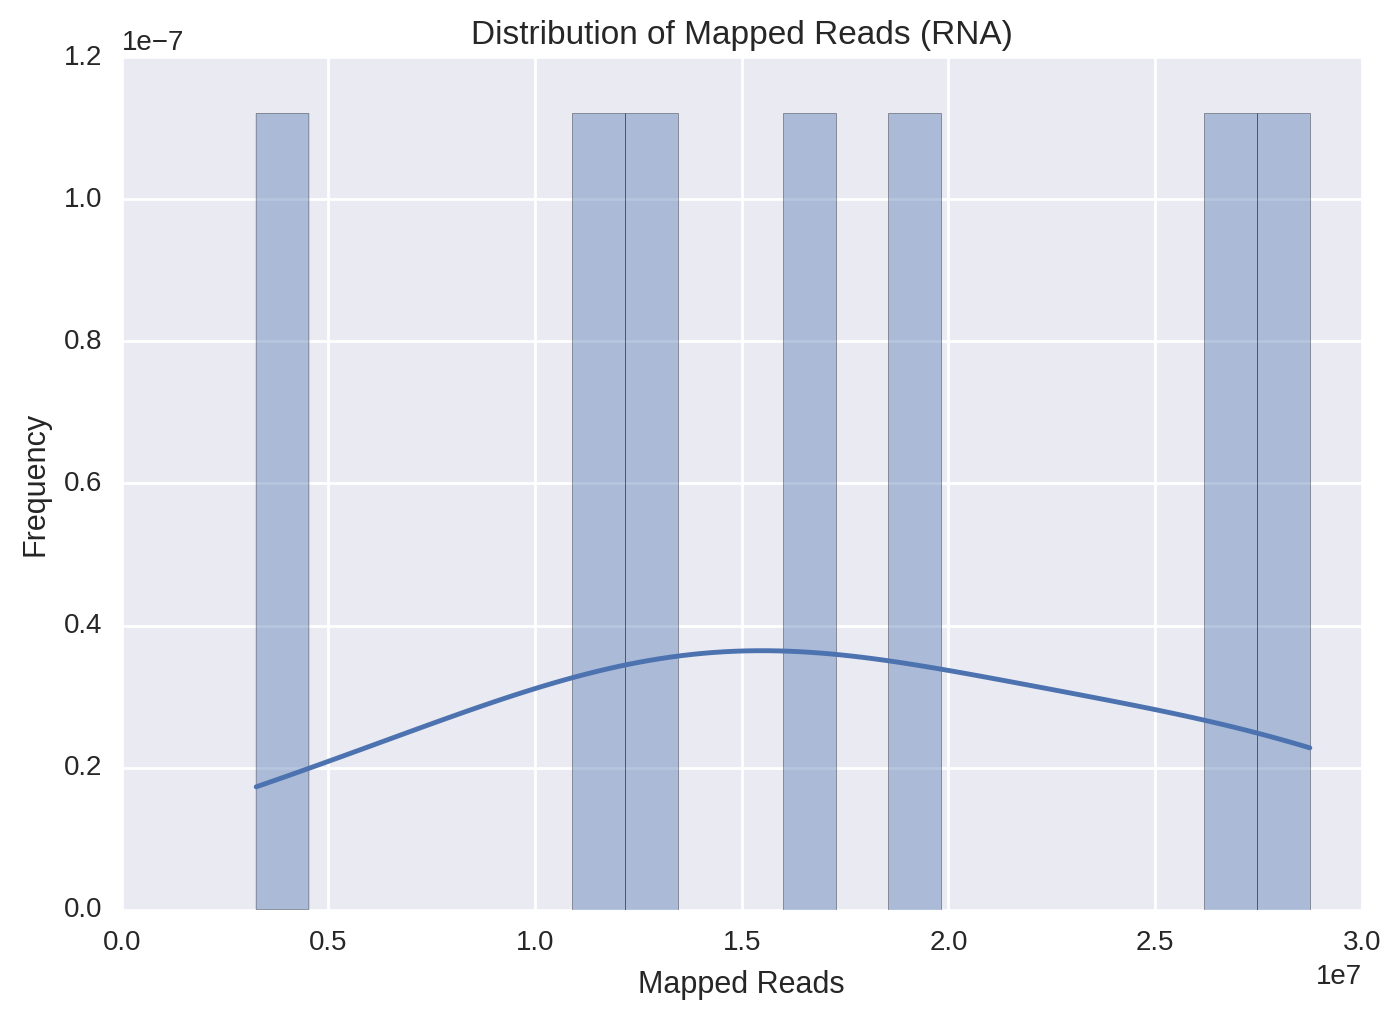

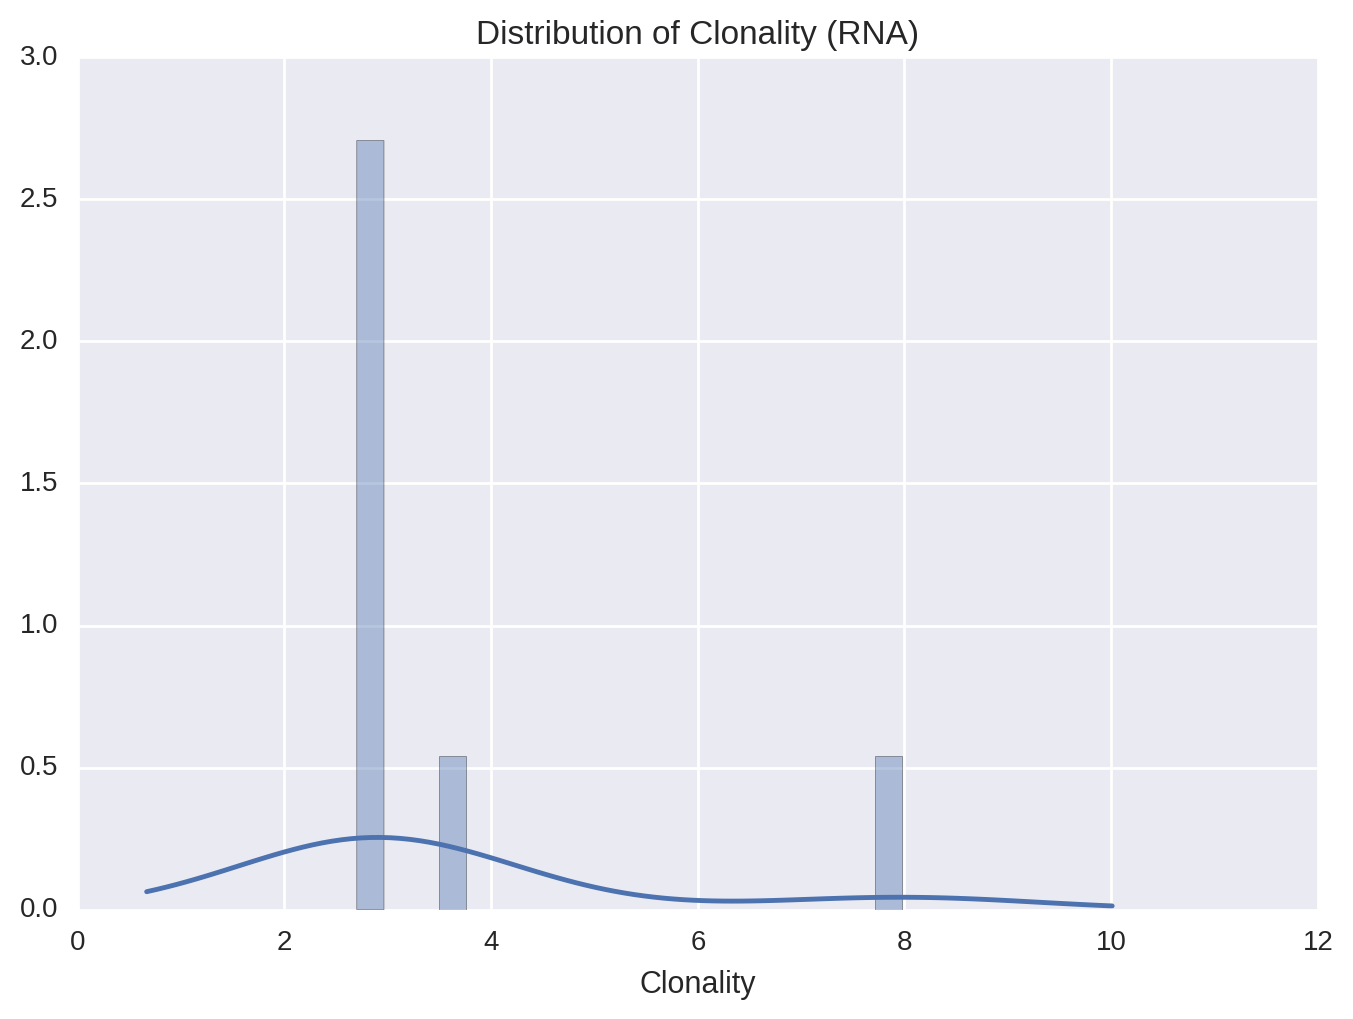

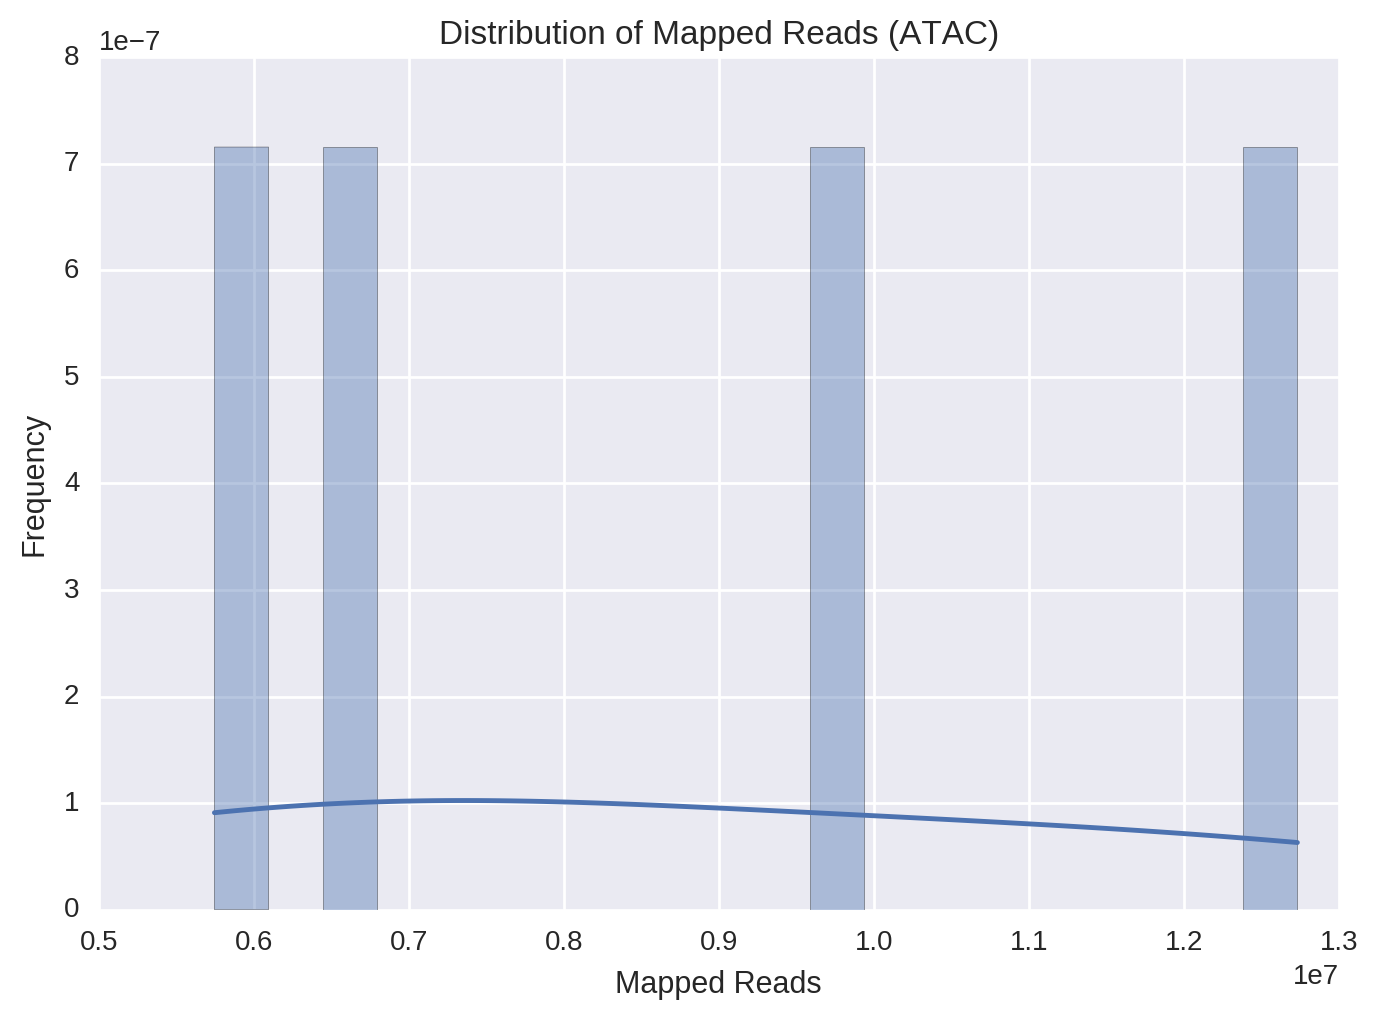

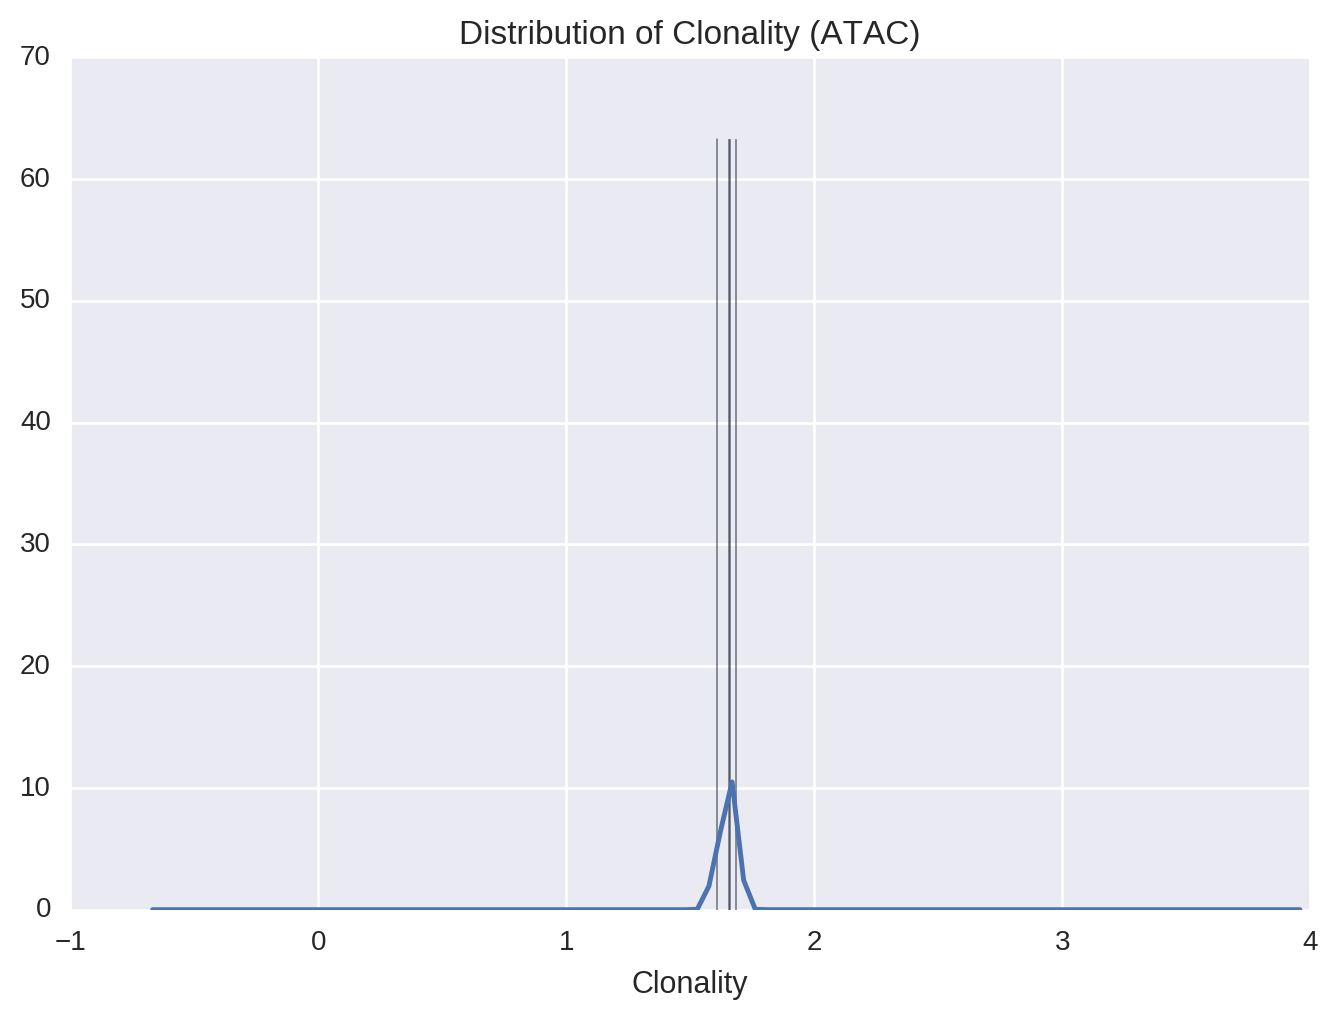

In [7]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame_atac['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (ATAC)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_atac['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (ATAC)')
plt.xlabel('Clonality')
plt.show()


In [8]:
filtered_summary_frame_atac = summary_frame_atac.copy()

In [9]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 1000000
pbcThreshold=0.0
# gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]

## Calculate RPKM Values

In [ ]:
filteredTagDirectories = ' '.join(['/home/jenhan/analysis/atac_analysis//tag_directories_rna/' +x for x in filtered_summary_frame_rna['sampleName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv



In [10]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]


raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

### Run IDR

In [ ]:
# %%capture
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_rna/'
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['Cell Type'] +
                                             '_' + filtered_summary_frame_rna['treatment']))
originalName_strain_dict = dict(zip(filtered_summary_frame_rna['sampleName'], filtered_summary_frame_rna['strain']))

conditions = " ".join([originalName_strain_dict[x] + '_' + originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

In [15]:
idr_rpkm_frame = pd.read_csv('idr_rna/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = idr_rpkm_median_frame.sort()

idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame.to_pickle('idr_rpkm_median_frame.pickle')

In [16]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['strain'] 
                                 + '_'+ filtered_summary_frame_rna['Cell Type']
                                 + '_'+ filtered_summary_frame_rna['treatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x.split('/')[-1]] for x in samples])
! getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats C57Bl6_Thiomac_KLA vs. C57Bl6_Thiomac_Veh:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_Thiomac_Veh vs. C57Bl6_Thiomac_KLA: 10 (0.041%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_Thiomac_Veh vs. C57Bl6_Thiomac_KLA: 206 (0.842%) [log2fold<-1, FDR<0.05]



In [17]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

## ATAC-seq Peak Calling

In [10]:
### call peaks ###
peakDirectory = '/home/jenhan/analysis/atac_analysis/peak_files'
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names

for sn in filtered_summary_frame_atac['sampleName'].values:
    
    peakFileName = sn + "_peaks.tsv"

    print('findPeaks ' + tagDirPath + '/' + sn + 
                     ' -L 0 -C 0 -fdr 0.9' +
                     ' -style factor -size 200  > ' + 
                     peakDirectory +'/' + peakFileName + ' &')



findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATA

In [11]:
%%bash
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &

	Fragment Length = 67
	Total Tags = 12733303.0
	Tags per bp = 0.006367
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 67
	Total Tags = 6737504.0
	Tags per bp = 0.003369
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 67
	Total Tags = 5746574.0
	Tags per bp = 0.002873
	Max tags per bp set automatically to 1.0
	Fragment Length = 77
	Total Tags = 9726543.0
	Tags per bp = 0.004863
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
		Finding peaks on chr1 (minCount=-0.4), total tags positions = 273690
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 317898
		Finding peaks on chr1 (minCount=-0.0), total tags positions = 448119
		Finding peaks on chr1 (minCount=0.3), total tags positions = 571010
		Finding peaks on chr2 (minCount=-0.4), total tags positions = 267441
		Finding

### Run IDR

In [12]:
! rm ./idr_atac/*
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame_atac.index):
    factor_treatment_rows = filtered_summary_frame_atac.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame_atac.ix[ri, 'sampleName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            !echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            

python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &


In [13]:
%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &

Performing IDR analysis on the following samples: /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv, /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv
Output files will be written to: /home/jenhan/analysis/atac_analysis/idr_atac/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.narrowPeak /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.narrowPeak --output-file /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jenhan/analysis/

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.12 1.48 0.93 0.63]
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/idr-2.0.2-py3.4-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 34036/63788 (53.4%)

Number of peaks passing IDR cutoff of 0.05 - 34036/63788 (53.4%)

Final parameter values: [2.64 1.64 0.96 0.66]
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/idr-2.0.2-py3.4-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 59389/96847 (61.3%)

Number of peaks passing IDR cutoff of 0.05 - 59389/96847 (61.3%)



In [14]:
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'
count_dict = {}
for f in os.listdir(idrDirectory):
    if 'idr.tsv' in f:
        tokens = f.split('_')
        strain = tokens[0]
        cellType = tokens[1]
        treatment = tokens[3].split('-')[0]
        condition = '_'.join([strain, cellType, treatment])
        with open(idrDirectory + f) as file:
            data = file.readlines()
        numPeaks = len(data) - 1
        if not condition in count_dict:
            count_dict[condition] = (f, numPeaks)
        else:
            if numPeaks > count_dict[condition][1]:
                count_dict[condition] = (f, numPeaks)        
for key in count_dict:
    idrResult = count_dict[key][0]
    peakFileName = key+'_peaks.tsv'

    !echo cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName
    !cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName

cp /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks_C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks_idr.tsv ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv
cp /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.tsv ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv


### Merge peak files

In [44]:
! mergePeaks -d given -venn venn.txt ./idr_peak_files/* > ./merged_peaks.tsv
! makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./idr_peak_files/*

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total) and ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total) and ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total) and ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total) and ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total)

Finished reading merged peak file...
Integrating scores for C57Bl6_Thiomac_KLA
Integrating scores for C57Bl6_Thiomac_Veh


In [20]:
# read in peak data data
peak_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
peak_frame = peak_frame.fillna('0')
for col in peak_frame.columns[5:]:
    floatValues = []
    for val in peak_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    peak_frame[col] = floatValues
peak_frame.index = peak_frame['ID'].values

# remove peaks in unknown/random chromosomes
peak_frame = peak_frame[~peak_frame['chr'].str.contains('random')]
peak_frame = peak_frame[~peak_frame['chr'].str.contains('Un')]



### Create background peaks from genomic sequences from each chromosome

In [63]:
! if [ ! -d ./group_by_chromosome ]; then mkdir ./group_by_chromosome; fi
! rm -rf ./group_by_chromosome/*


rm: cannot remove ‘./group_by_chromosome/chr4’: Directory not empty


In [64]:
peakSize = 200 # size of artificial background peaks
N_threshold = 0.5 # throw away background peaks containing greater than this fraction of N

tile_peak_file = open('./group/merged_tile_peaks.tsv','w')

tile_peak_file.write('\t'.join(['#ID', 'chr', 'start', 'end', 'strand\n']))

for f in os.listdir('./mm10_genome/'):
    if '.fa' in f and not f in ['chrY.fa', 'chrM.fa'] :
        current_chromosome = f.split('.')[0]
        print(current_chromosome)
        
        # create seperate peak file containing just this chromosome
        if not os.path.isdir('./group_by_chromosome/'+current_chromosome):
            os.mkdir('./group_by_chromosome/'+current_chromosome)
        current_tile_peak_file = open(
            './group_by_chromosome/'+ current_chromosome + '/' + current_chromosome +'_tile_peaks.tsv','w')
        current_tile_peak_file.write('\t'.join(['#ID', 'chr', 'start', 'end', 'strand\n']))
        
        # read in fastq file line by line
        with open('./mm10_genome/' + f) as chromosome_file:
            data = chromosome_file.readlines()
        genome_seq = ''
        for line in data[1:]:
            genome_seq += line.strip().upper()
        genome_seq_size = len(genome_seq)
        
        # create array indicating if position is N
        is_N = [True if x == 'N' else False for x in genome_seq]

        # create array indicating if position overlaps with a peak
        # simultaneously write ATAC-seq peaks
        is_peak = [False for x in genome_seq]
        current_peak_frame = peak_frame[(peak_frame['chr'] == current_chromosome) &
                                        (peak_frame['Factors'].str.contains('Veh'))] # only work with vehicle peaks for now

        positions = list(zip(current_peak_frame['ID'].values, current_peak_frame['start'].values, current_peak_frame['end'].values))
        for pos in positions:
            ID = pos[0]
            start = pos[1] - 1
            end = pos[2]
            for i in range(start, end):
                is_peak[i] = True
            tile_peak_file.write('\t'.join([ID, current_chromosome, str(start), str(end), '+\n']))  
            current_tile_peak_file.write('\t'.join([ID, current_chromosome, str(start), str(end), '+\n']))  
        
        # write background peak files
        for i in range(0,genome_seq_size, peakSize):
            n_count = np.sum(is_N[i:i+peakSize+1])
            if not n_count > peakSize * N_threshold:
                if not np.sum(is_peak[i:i+peakSize+1]) > 0:
                    tile_peak_file.write('\t'.join(['tile_'+str(i), current_chromosome, str(i), str(i+peakSize), '+\n']))        
                    current_tile_peak_file.write('\t'.join(['tile_'+str(i), current_chromosome, str(i), str(i+peakSize), '+\n']))        

        current_tile_peak_file.close()
tile_peak_file.close()  

chr4
chr5
chr7
chr6
chr2
chr3
chr19
chr1
chr18
chr9
chr11
chr10
chr8
chrX
chr12
chr13
chr17
chr16
chr14
chr15


### Extract genomic sequences for each set of peak files

In [72]:
peakDirectory =  './group_by_chromosome/'
for chrom in os.listdir(peakDirectory):
    peakPath = peakDirectory + chrom + '/' + chrom + '_tile_peaks.tsv'
    seqPath = peakPath.replace('_peaks.tsv','.fa')
    !homerTools extract $peakPath /bioinformatics/homer/data/genomes/mm10 -fa > $seqPath

    


	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 729181 sequences from chr6

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 501482 sequences from chr15

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 582712 sequences from chr12

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 435763 sequences from chr18

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 956420 sequences from chr1

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 737162 sequences from chr5

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 473514 sequences from chr16

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 591421 sequences from chr11

	Extracting sequences from directory: /bioinformat

## Scan Peaks for Motifs

In [87]:
# create a script to scan for motifs using FIMO
! if [ ! -d ./fimo_results/ ]; then mkdir ./fimo_results/; fi
! if [ ! -d ./fimo_out/ ]; then mkdir ./fimo_out/; fi


pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
fimo_results_dir = './fimo_results'


peakDirectory =  './group_by_chromosome/'
for chrom in os.listdir(peakDirectory):
    scriptFile = open('scanMotifs_' + chrom + '.sh','w')
    for m in os.listdir(motif_dir):
        fimo_out_dir = './fimo_out/' + chrom + '_' + m.replace('.fimo','')

        if 'fimo' in m:
            outPath = fimo_results_dir + '/' +chrom + '_'+ m.replace('.fimo','') +'.txt'
            scriptFile.write(
                'fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                str(pthresh)  + ' ' +
                motif_dir + '/' + m + ' ./group_by_chromosome/' + chrom + '/' + chrom + '_tile.fa ' +
                '> ' + outPath + ' & \n')
    scriptFile.close()





In [ ]:
%%bash
chmod a+x ./scanMotifs*.sh
for i in ./scanMotifs*sh; 
    do echo 'sleeping...';
    echo $i;
    $i;
    sleep 5m;
done


## Read in Score Files

### From Pickles

In [ ]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
peak_frame = pd.read_pickle('peak_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))

      
### work with just intergenic peaks for now ###
# intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
# motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
# motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
# motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
# motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
# motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
# normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
# scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
# annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]


### read in sequences as dictionary {peakID: sequence}
with open('./group/merged_tile.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()   
        
        
        
idr_rpkm_frame = pd.read_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame = pd.read_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame = pd.read_pickle('idr_rpkm_median_frame.pickle')

### Motif Scores

In [92]:
!ls ./group_by_chromosome/chr1

chr1_tile.fa  chr1_tile_peaks.tsv


In [100]:
current_peak_frame.head()

,#ID,chr,start,end,strand
0,Merged-chr4-59823711-1,chr4,59823608,59823813,+
1,Merged-chr4-28912248-1,chr4,28912142,28912353,+
2,Merged-chr4-47696184-1,chr4,47696083,47696284,+
3,Merged-chr4-63557449-1,chr4,63557335,63557562,+
4,Merged-chr4-66822669-1,chr4,66822568,66822769,+


In [ ]:
###  create pickles for each chromosome
! if [ ! -d ./pickles ]; then mkdir ./pickles; fi
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

peakDirectory =  './group_by_chromosome/'

for chrom in os.listdir(peakDirectory):
    peak_frame = pd.read_csv('./group_by_chromosome/' + chrom + '/' + chrom + '_tile_peaks.tsv', sep='\t')
    columns = peak_frame.columns.values
    columns[0] = 'ID'
    peak_frame.columns = columns
    peak_frame['Factors'] = ['atac' if not 'tile' in x else 'tile' for x in peak_frame['ID'].values]
    
    peak_start_dict = dict(zip(peak_frame['ID'].values, peak_frame['start'].values))

    motif_score_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_score_frame.index=motif_score_frame['ID'].values

    motif_sequence_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_sequence_frame.index=motif_score_frame['ID'].values

    motif_strand_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_strand_frame.index=motif_score_frame['ID'].values

    motif_start_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_start_frame.index=motif_score_frame['ID'].values

    motif_end_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_end_frame.index=motif_score_frame['ID'].values

    motif_count_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_count_frame.index = motif_count_frame['ID'].values

    counter=0
    for m in sorted(os.listdir(motif_dir)):
        counter+=1

        if '.fimo' in m:
            print(chrom, counter,m)
            motif_results = './fimo_results/' + chrom + '_' + m.replace('.fimo','') +'.txt'
            fimo_result_frame=pd.read_csv(motif_results, 
                                          skiprows=1,
                                          names=['motif_name', 
                                                 'peak_id', 
                                                 'start', 
                                                 'stop', 
                                                 'strand', 
                                                 'score', 
                                                 'pvalue', 
                                                 'sequence'],
                                          sep='\t')
            motif_name = m.replace('.fimo','')
            id_score_dict = {}
            id_strand_dict = {}
            id_sequence_dict = {}
            id_start_dict = {}
            id_end_dict = {}
            id_count_dict = {}

            ids = fimo_result_frame['peak_id'].values
            scores = fimo_result_frame['score'].values
            strands = fimo_result_frame['strand'].values
            sequences = fimo_result_frame['sequence']
            starts = fimo_result_frame['start']
            ends = fimo_result_frame['stop']

            for i in range(len(ids)):
                currentScore = float(scores[i])
                currentSequence = sequences[i]
                currentStrand = strands[i]
                currentStart = int(starts[i])
                currentEnd = int(ends[i])
                if currentScore < 0.0:
                    currentScore = 0.0
                if ids[i] in id_score_dict:
                    if currentScore > id_score_dict[ids[i]]:
                        id_score_dict[ids[i]] = currentScore
                        id_sequence_dict[ids[i]] = currentSequence
                        id_strand_dict[ids[i]] = currentStrand
                        id_start_dict[ids[i]] = currentStart
                        id_end_dict[ids[i]] = currentEnd
                        id_count_dict[ids[i]] += 1
                else:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] = 0

            motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
            motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
            motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
            motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
            motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
            motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]

    motif_score_frame.to_pickle('./pickles/chrom' + '_motif_score_frame.pickle')

    motif_sequence_frame.to_pickle('./pickles/chrom' + '_motif_sequence_frame.pickle')

    motif_strand_frame.to_pickle('./pickles/chrom' + '_motif_strand_frame.pickle')

    motif_start_frame.to_pickle('./pickles/chrom' + '_motif_start_frame.pickle')

    motif_end_frame.to_pickle('./pickles/chrom' + '_motif_end_frame.pickle')

    motif_count_frame.to_pickle('./pickles/chrom' + '_motif_count_frame.pickle')

    scaler = preprocessing.MinMaxScaler()
    normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
    normed_motif_frame.columns = motif_score_frame.columns.values[3:]
    normed_motif_frame.index = motif_score_frame.index.values
    
    normed_motif_frame.to_pickle('./pickles/chrom' + '_normed_motif_frame.pickle')

## Actual Analysis?..

In [ ]:

# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

In [ ]:
sns.boxplot(normed_motif_frame.ix[:,3:].values.flatten())

In [ ]:
# plot distribution of motif scores
sns.set_context('notebook', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in motif_score_frame.columns[3:]:
    data_dict[col] = motif_score_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.show()
del data_dict
sns.set_context('talk', font_scale=1.0)

# plot distribution of normed motif scores
sns.set_context('notebook', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in normed_motif_frame.columns:
    data_dict[col] = normed_motif_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
del data_dict
plt.show()
sns.set_context('notebook', font_scale=1.0)

sns.distplot(motif_score_frame.ix[:,3:].values.flatten())
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('Motif Score')
plt.ylabel('Frequency')
plt.show()
sns.distplot(normed_motif_frame.ix[:,3:].values.flatten())
# plt.xlim(-0.05, 0.05)
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('NormalizedMotif Score')
plt.ylabel('Frequency')

In [ ]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = motif_score_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = motif_score_frame[motif1].values
        motifScores2 = motif_score_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho
        motif_corr_pearson_matrix[j][i] = r
        motif_corr_spearman_matrix[j][i] = rho


# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Spearman Correlation')
plt.show()

In [ ]:
sns.distplot(motif_corr_pearson_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Pearson Correlations')
plt.show()
sns.distplot(motif_corr_spearman_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Spearman Correlations')

In [187]:
np.sum(labels)

529

In [ ]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
factors = ['C57Bl6_Thiomac_Veh']
for factor in factors:
    features = normed_motif_frame
    labels = peak_frame['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_matched_split(
        features, labels, test_size = 0.2)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame = pd.DataFrame(factor_coeff_dict)
coefficients_frame = coefficients_frame[factors]
coefficients_frame.index = normed_motif_frame.columns.values


In [ ]:
sns.set_context('notebook', font_scale=1.0)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
factor_auc_dict_all

In [ ]:
factor_coeff_dict

In [ ]:
threshold = 2.0
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame.columns.values:
    weights = coefficients_frame[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs.add(m)

        

In [ ]:
sns.distplot(coefficients_frame.values.flatten())
plt.ylabel('KDE')
plt.xlabel('Weight')

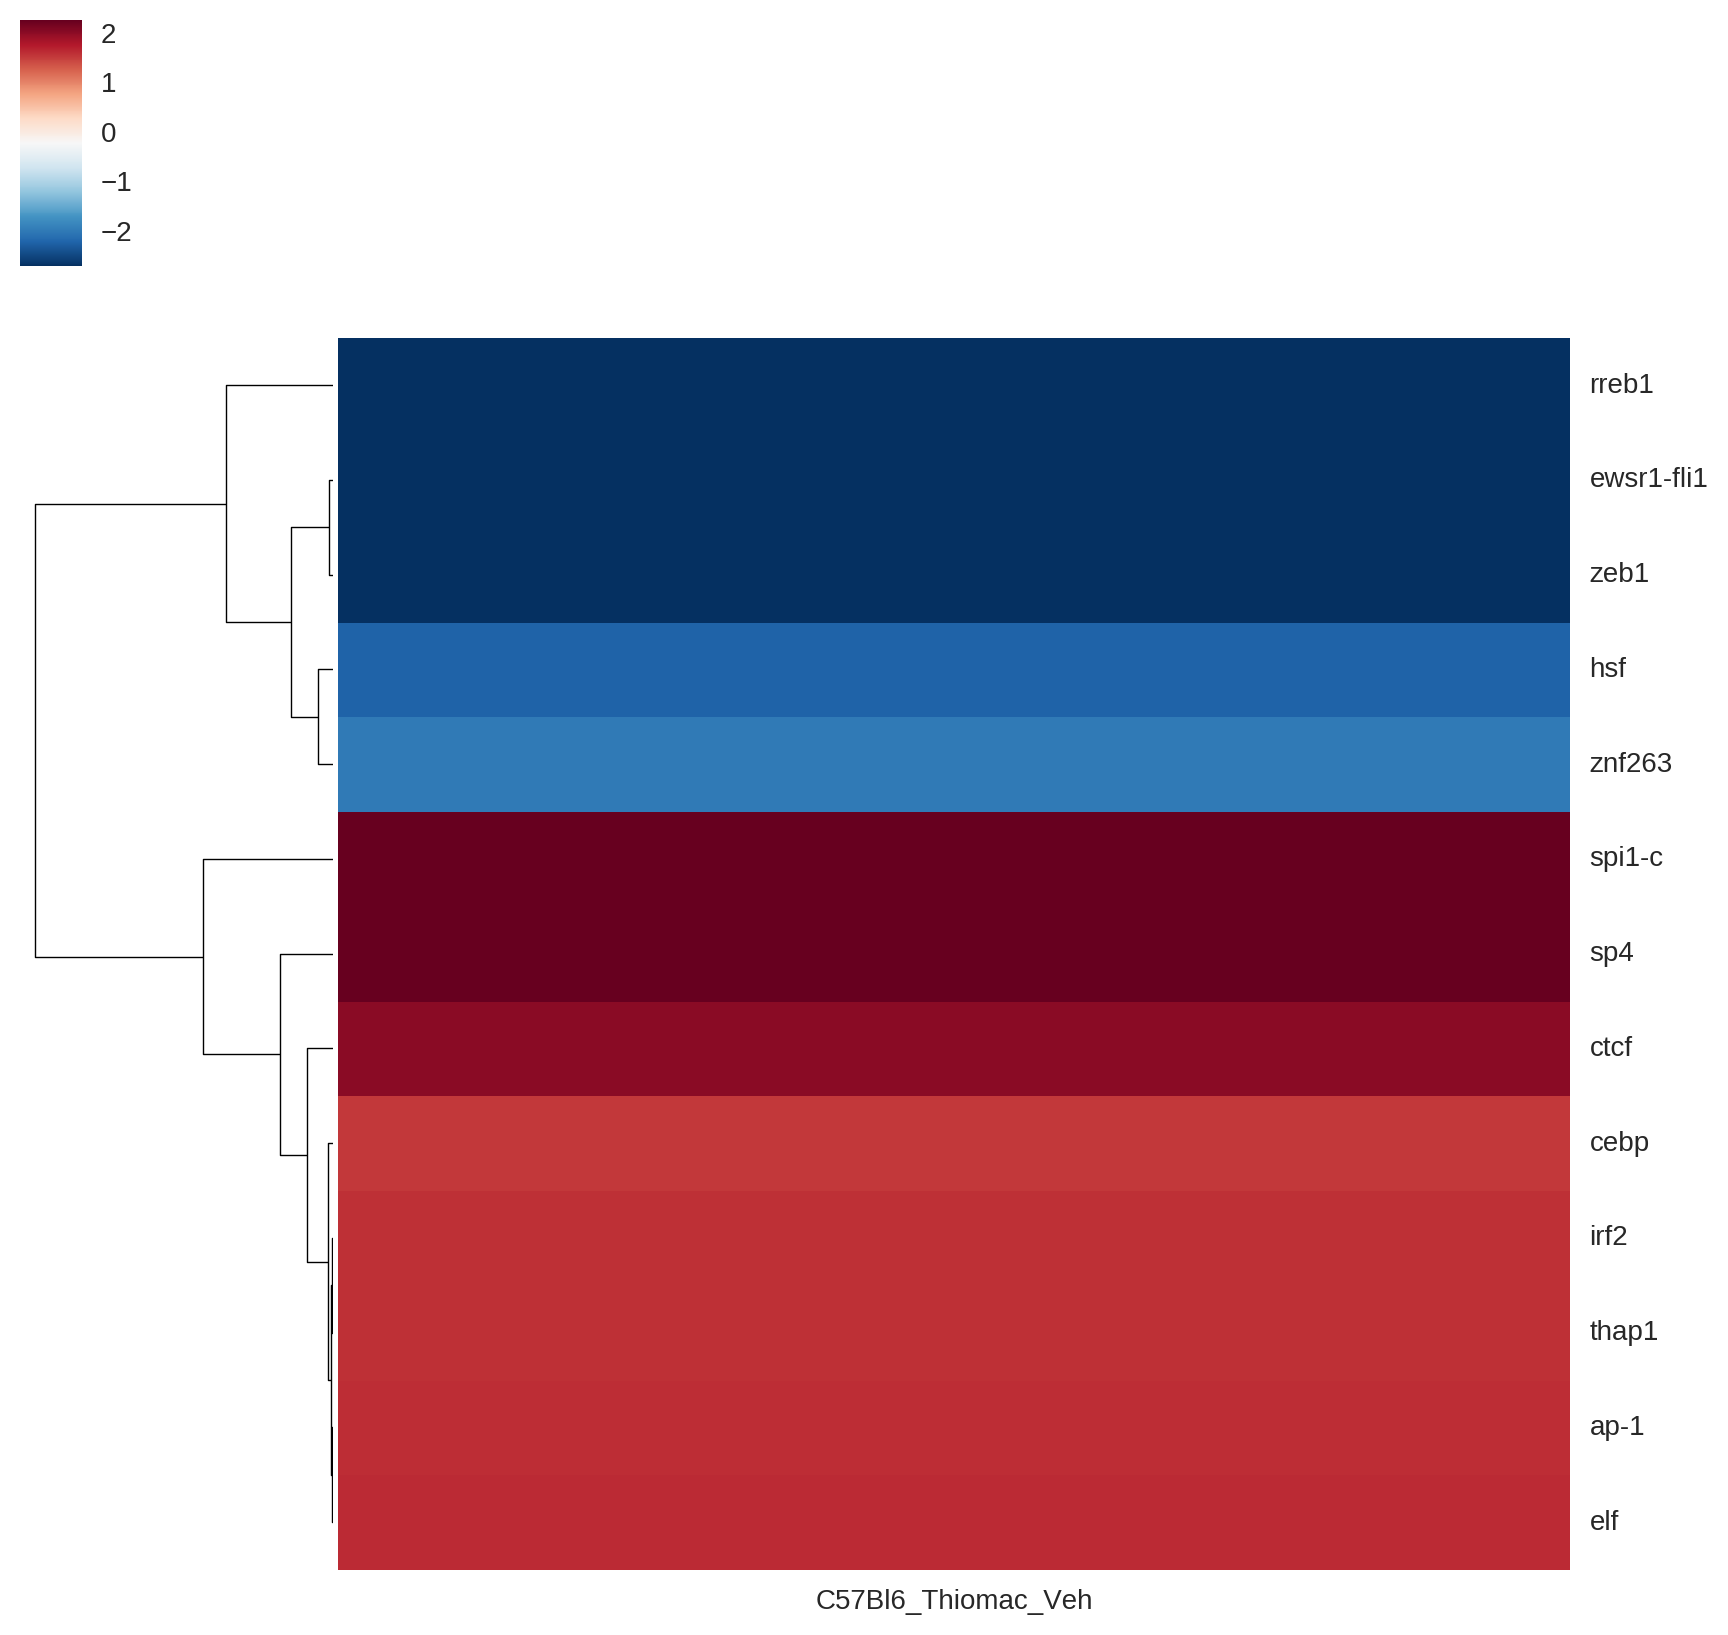

In [270]:
threshold = 3
coeff_std = np.std(coefficients_frame.values.flatten())
coeff_mean = np.mean(coefficients_frame.values.flatten())
data = coefficients_frame[coefficients_frame.index.isin(significant_motifs)]

# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},
                       col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);